In [3]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
path_1 = 'dataset/HAM10000_images_part_1'
path_2 = 'dataset/HAM10000_images_part_2'
meta_path = 'dataset/HAM10000_metadata.csv'
classes = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
encoder = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}
no_classes = len(classes)
meta = pd.read_csv(meta_path)
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

images_data = []
labels = []
missed = []

for i in range(len(meta)):
    row = meta.iloc[i]
    image_name = row['image_id']
    image_class = row['dx']
    image = []
    image_path = os.path.join(path_1, image_name + '.jpg') if os.path.exists(os.path.join(path_1, image_name + '.jpg')) else os.path.join(path_2, image_name + '.jpg')
    
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    
    images_data.append(image)
    labels.append(encoder[image_class])

# images_data = np.array(images_data)
# labels = np.array(labels)

In [ ]:
# for i, img_name in enumerate(os.listdir(path_1)):
#     class_name = meta.loc[meta.image_id == img_name.split('.')[0]].dx.values[0]
#     img = cv.imread(os.path.join(path_1,img_name))
#     h,w,_ = img.shape
#     heights.append(h)
#     widths.append(w)
#     images_data.append(img)
#     labels.append(encoder[class_name])

# for i, img_name in enumerate(os.listdir(path_2)):
#     class_name = meta.loc[meta.image_id == img_name.split('.')[0]].dx.values[0]
#     img = cv.imread(os.path.join(path_2,img_name))
#     h,w,_ = img.shape
#     heights.append(h)
#     widths.append(w)
#     images_data.append(img)
#     labels.append(encoder[class_name])

In [4]:
images_data = np.array(images_data)
labels = np.array(labels)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

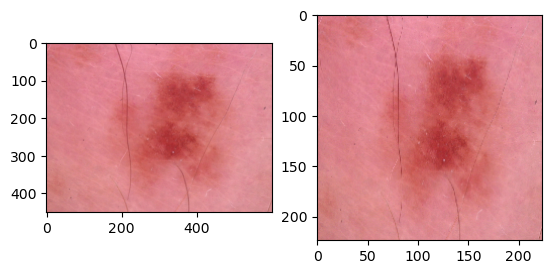

In [19]:
plt.subplot(1,2,1)
rando_img = load_img('dataset/HAM10000_images_part_1/ISIC_0024307.jpg', )
rando_img = img_to_array(rando_img)
rando_img = np.array(rando_img)/255
plt.imshow(rando_img)
plt.subplot(1,2,2)
rando_img = load_img('dataset/HAM10000_images_part_1/ISIC_0024307.jpg', target_size=(224, 224))
rando_img = img_to_array(rando_img)
rando_img = np.array(rando_img)/255
plt.imshow(rando_img)

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(no_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 26, 26, 128)     

In [25]:
# print(y_train[:5])
y_train = tf.keras.utils.to_categorical(y_train, no_classes)
y_test = tf.keras.utils.to_categorical(y_test, no_classes)
y_val = tf.keras.utils.to_categorical(y_val, no_classes)
print(y_train[:5])

[[0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [31]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
)

Epoch 1/10
188/188 [==============================] - 228s 1s/step - loss: 0.9516 - accuracy: 0.6772 - val_loss: 0.9199 - val_accuracy: 0.6605
Epoch 2/10
188/188 [==============================] - 221s 1s/step - loss: 0.8695 - accuracy: 0.6920 - val_loss: 0.9248 - val_accuracy: 0.6600
Epoch 3/10
188/188 [==============================] - 238s 1s/step - loss: 0.8017 - accuracy: 0.7066 - val_loss: 0.8680 - val_accuracy: 0.6835
Epoch 4/10
188/188 [==============================] - 267s 1s/step - loss: 0.7384 - accuracy: 0.7306 - val_loss: 0.8624 - val_accuracy: 0.6960
Epoch 5/10
188/188 [==============================] - 238s 1s/step - loss: 0.6685 - accuracy: 0.7512 - val_loss: 0.8601 - val_accuracy: 0.7059
Epoch 6/10
188/188 [==============================] - 244s 1s/step - loss: 0.6187 - accuracy: 0.7690 - val_loss: 0.9415 - val_accuracy: 0.6960
Epoch 7/10
188/188 [==============================] - 220s 1s/step - loss: 0.5567 - accuracy: 0.7882 - val_loss: 0.9150 - val_accuracy: 0.7044

In [32]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

63/63 [==============================] - 22s 338ms/step - loss: 1.1817 - accuracy: 0.7094
Test Loss: 1.1817117929458618
Test Accuracy: 0.7094358205795288


In [33]:
model.save(f'diff_weights/custom_model2_{test_accuracy:.2f}_.h5')

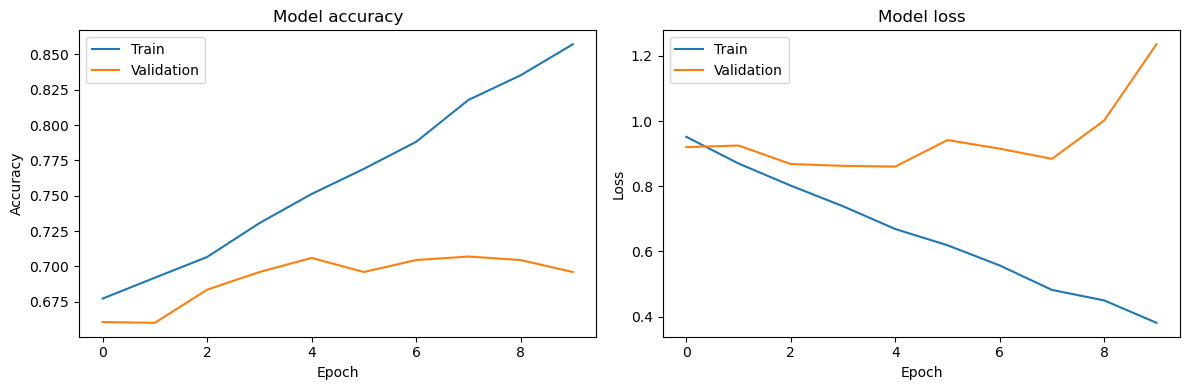

In [34]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


63/63 [==============================] - 23s 355ms/step


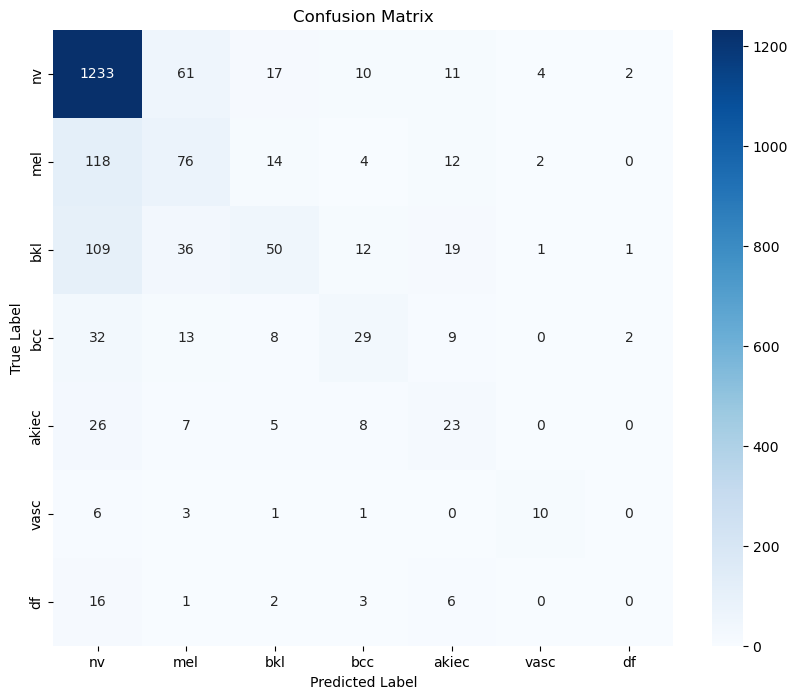

In [38]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes.keys(), yticklabels=classes.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
# class_report = classification_report(y_true, y_pred_classes, target_names=classes.keys())
# print(class_report)


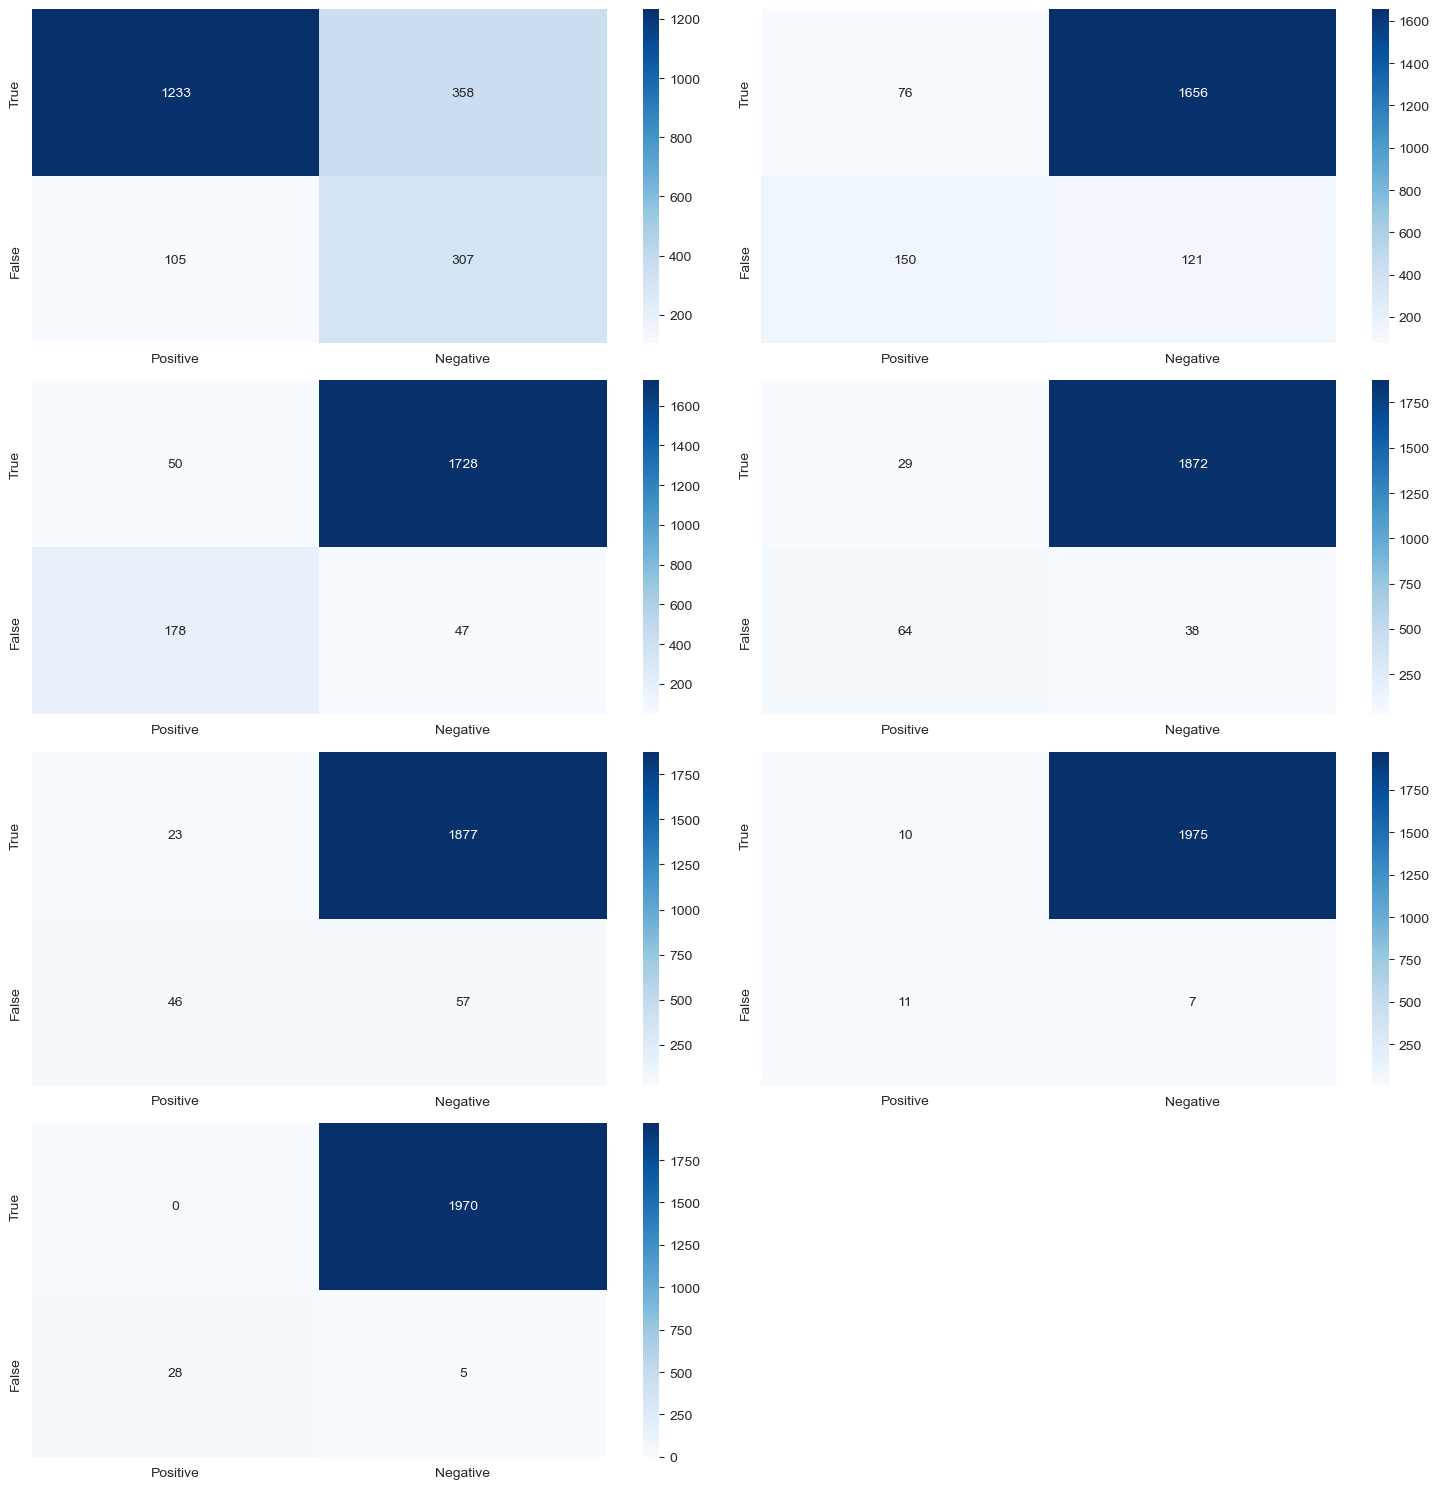

In [66]:
plt.figure(figsize=(15,15))
for i in range(no_classes):
    plt.subplot(4,2,i+1)
    true_positives = conf_matrix[i,i]
    true_negatives = np.sum(conf_matrix) - np.sum(conf_matrix[i,:]) - np.sum(conf_matrix[:,i]) + true_positives
    false_positives = conf_matrix[i,:].sum() - true_positives
    false_negatives = conf_matrix[:,i].sum() - true_positives
    mat = [[true_positives,true_negatives],[false_positives,false_negatives]]
    sns.set_style('darkgrid') 
    plt.gca().set_frame_on(True)
    sns.heatmap(mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive','Negative'], yticklabels=['True','False'])
plt.tight_layout()
plt.show()